## Frequentist Linear regression 

$$
\begin{align}
y = \beta^T X + \epsilon
\end{align}
$$

The goal of learning a linear model from training data is to find the coefficients, $\beta$, that best explain the data. 

In **frequentist** linear regression, the best explanation is taken to mean the coefficients, $\beta$, that minimize the residual sum of squares (RSS)

$$
\begin{align}
RSS(\beta) = \sum_{i=1}^{N} (y_i - \hat{y})^2
\end{align}
$$

This equation has a closed form solution for the model parameters, $\beta$, that minimize the error. This is known as the **maximum likelihood estimate of $\beta$** because it is the value that is the most probable given the inputs, $X$, and outputs, $y$

$$
\begin{align}
\hat{\beta} = (X^T X)^{-1} X^T y 
\end{align}
$$

This method of fitting the model parameters by minimizing the RSS is called **Ordinary Least Squares** (OLS).

>What we obtain from frequentist linear regression is a single estimate for the model parameters based only on the training data. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
import scipy
import pymc3 as pm

## Load data

In [2]:
exercise  = pd.read_csv('data/exercise.csv')
calories = pd.read_csv('data/calories.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df = df[df['Calories'] < 300]
df = df.reset_index()
df['Intercept'] = 1
df.head()

,index,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Intercept
0,0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,1
1,1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,1
2,2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,1
3,3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,1
4,4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,1


## Plot relationship

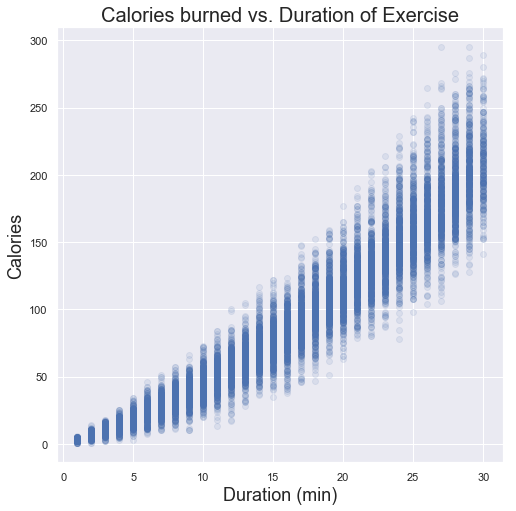

In [3]:
plt.figure(figsize=(8, 8))

plt.plot(df['Duration'], df['Calories'], 'bo', alpha = 0.1);
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.title('Calories burned vs. Duration of Exercise', size = 20);

In [4]:
# Create the features and response
X = df.loc[:, ['Intercept', 'Duration']]
y = df.loc[:, 'Calories']

## Implement Ordinary Least Squares Linear Regression

In [5]:
# Create the model and fit on the data
lr = LinearRegression()
lr.fit(X.Duration.values.reshape(-1, 1), y)
print('Intercept from library:', lr.intercept_)
print('Slope from library:', lr.coef_[0])

Intercept from library: -21.828102526050813
Slope from library: 7.169783349587853


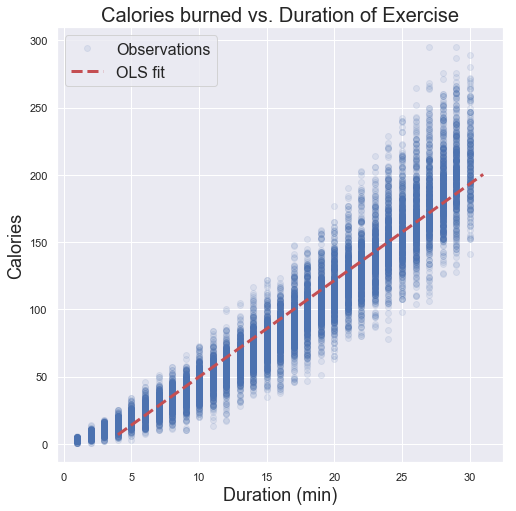

In [6]:
xs = np.linspace(4, 31, 1000)
ys = lr.intercept_ + lr.coef_[0] * xs

plt.figure(figsize=(8, 8))
plt.plot(df['Duration'], df['Calories'], 'bo', label = 'Observations', alpha = 0.1);
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.plot(xs, ys, 'r--', label = 'OLS fit', linewidth = 3)
plt.legend(prop={'size': 16})
plt.title('Calories burned vs. Duration of Exercise', size = 20);

## Bayesian Linear Regression

In the Bayesian viewpoint, we formulate linear regression using probability **distributions** rather than point estimates. The response, $y$, is not estimated as a single value, but is assumed to be drawn from a probability distribution.

$$
\begin{align}
y \sim N(\beta^T X, \sigma^2 I)
\end{align}
$$

The output, $y$ is generated from a normal (Gaussian) Distribution characterized by a mean and variance.

The aim of Bayesian Linear Regression is to determine the posterior distribution for the model parameters. Not only is the response generated from a probability distribution, but the model parameters are assumed to come from a distribution as well.

**This is the fundamental underpinning of Bayesian Inference**

$$
\begin{align}
Posterior = \frac{Likelihood * Prior}{Normalization}
\end{align}
$$

Two primary benefits of Bayesian Linear Regression.

1. **Priors**: If we have domain knowledge, or a guess for what the model parameters should be, we can include them in our model, unlike in the frequentist approach which assumes everything there is to know about the parameters comes from the data. If we don’t have any estimates ahead of time, we can use *non-informative priors* for the parameters such as a normal distribution.

2. **Posterior**: The result of performing Bayesian Linear Regression is a distribution of possible model parameters based on the data and the prior. This allows us to quantify our uncertainty about the model: if we have fewer data points, the posterior distribution will be more spread out.

>As the amount of data points increases, the likelihood washes out the prior, and in the case of infinite data, the outputs for the parameters converge to the values obtained from OLS.

>**Bayesian worldview**: we start out with an initial estimate, our prior, and as we gather more evidence, **our model becomes less wrong**. Bayesian reasoning is a natural extension of our intuition.

## Implement Bayesian Linear Regression

In [16]:
with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[:, 'Duration']
    #mean = pm.Deterministic('mean', intercept + slope * X.loc[:, 'Duration'])
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(1000, step, tune=700)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, slope, Intercept]
Could not pickle model, sampling singlethreaded.
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, slope, Intercept]
100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:41<00:00, 362.40it/s]
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


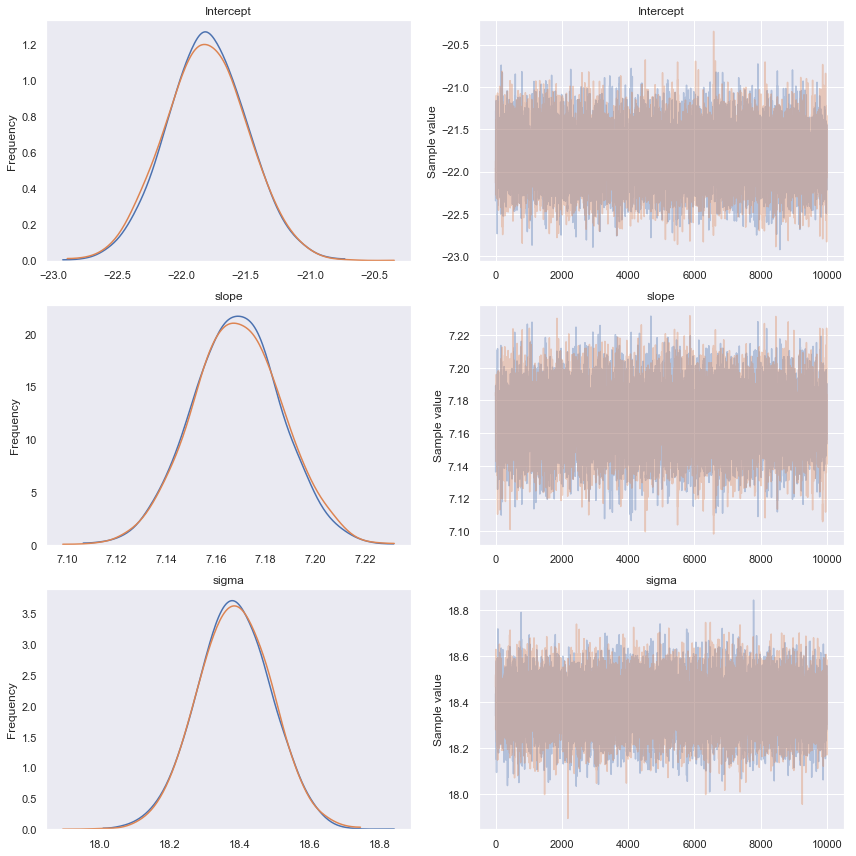

In [17]:
pm.traceplot(linear_trace, figsize = (12, 12));

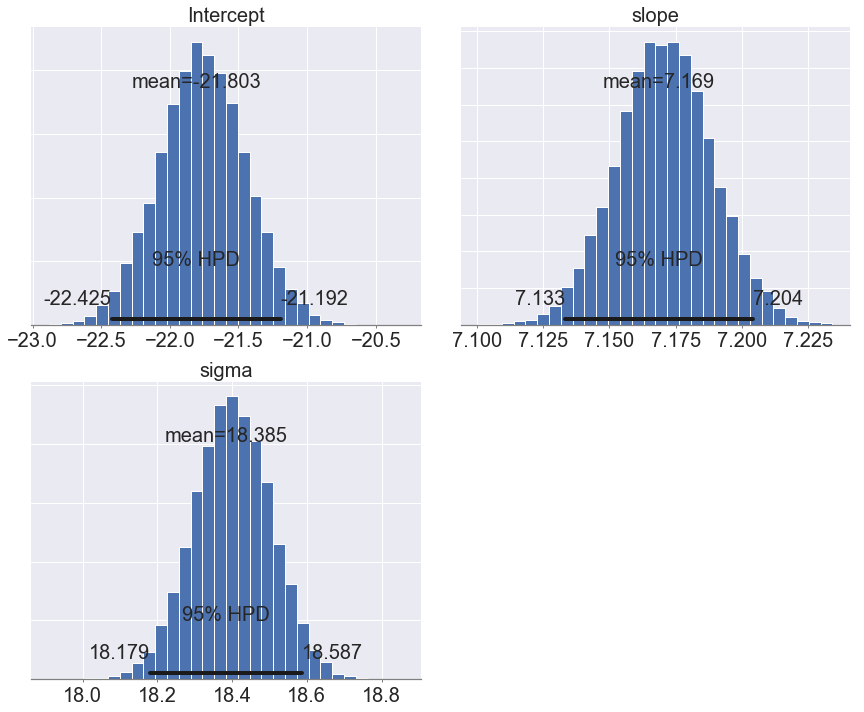

In [18]:
pm.plot_posterior(linear_trace, figsize = (12, 10), text_size = 20);

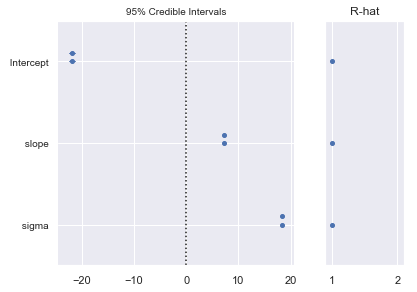

In [21]:
pm.forestplot(linear_trace);

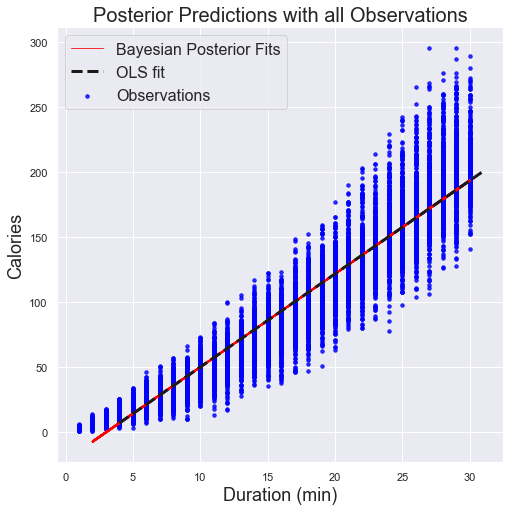

In [24]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(xs, ys, 'k--', label = 'OLS fit', linewidth = 3)
#plt.plot(X['Duration'], by_hand_coefs[0] + X['Duration'] * by_hand_coefs[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with all Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

In [26]:
pm.summary(linear_trace)

C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-21.803102,0.315059,0.003193,-22.424569,-21.192045,9580.556969,1.000144
slope,7.168524,0.017947,0.000180,7.133290,7.204058,9608.480705,1.000180
sigma,18.385069,0.104498,0.000988,18.179155,18.586961,13991.436362,1.000068


In [28]:
bayes_prediction = linear_trace['Intercept'] + linear_trace['slope'] * 15.5

C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\envs\dev-py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


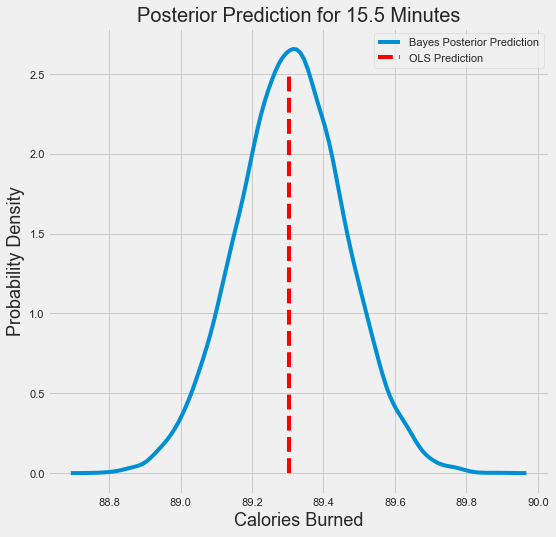

In [33]:
plt.figure(figsize = (8, 8))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction, label = 'Bayes Posterior Prediction')

plt.vlines(x = lr.intercept_ + lr.coef_[0]  * 15.5, 
           ymin = 0, ymax = 2.5, 
           label = 'OLS Prediction',
          colors = 'red', linestyles='--')
plt.legend();
plt.xlabel('Calories Burned', size = 18), plt.ylabel('Probability Density', size = 18);
plt.title('Posterior Prediction for 15.5 Minutes', size = 20);